In [8]:
# === STEP 1: UPLOAD EXTENDED DATASET ===
from google.colab import files
uploaded = files.upload()


Saving extended_xrp_forecast.csv to extended_xrp_forecast (1).csv


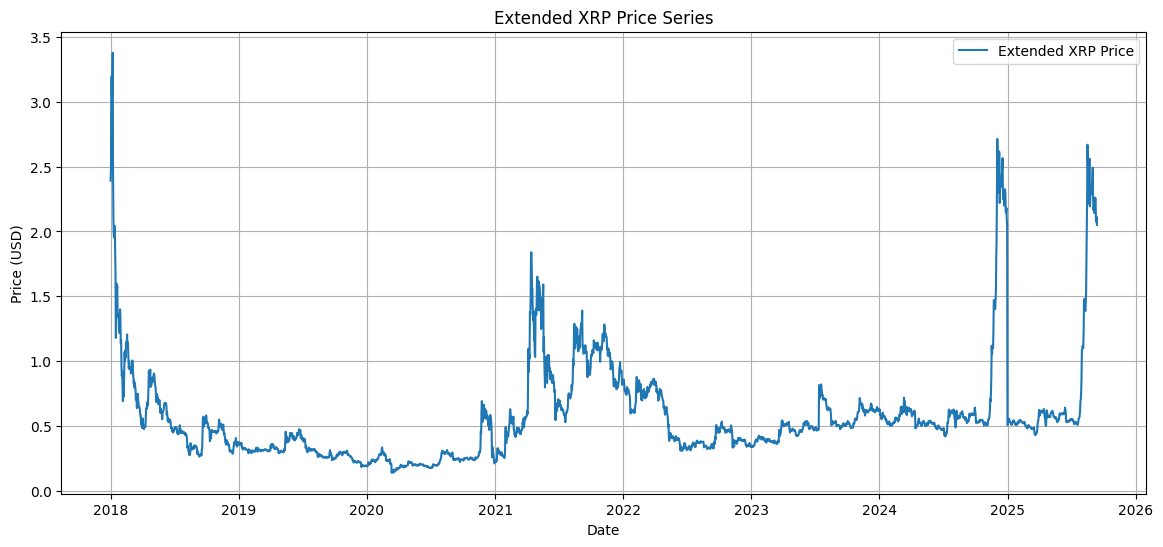

In [9]:
# === STEP 2: LOAD EXTENDED CSV INTO DATAFRAME ===
import pandas as pd

df_ext = pd.read_csv('extended_xrp_forecast.csv')
df_ext['Date'] = pd.to_datetime(df_ext['Date'])

# Plot to verify
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_ext['Date'], df_ext['Price'], label='Extended XRP Price')
plt.title('Extended XRP Price Series')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()


In [10]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Use last 1000 samples only
cutoff = 1000
series = df_ext['Price'].values[-cutoff:].reshape(-1, 1)


# Normalize
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# Create sequences
def create_sequence_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X_seq, y_seq = create_sequence_data(scaled_series, window_size)

# Train/test split
X_train, y_train = X_seq[:-30], y_seq[:-30]
X_test, y_test = X_seq[-30:], y_seq[-30:]

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)


In [11]:
import torch.nn as nn

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        return self.decoder(x)


In [16]:
model = SimpleTransformer(input_dim=1, model_dim=64, num_heads=4, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([940, 1, 1])) that is different to the input size (torch.Size([940, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.1654
Epoch 5, Loss: 0.4511
Epoch 10, Loss: 0.0905
Epoch 15, Loss: 0.0334
Epoch 20, Loss: 0.0694
Epoch 25, Loss: 0.0275


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([12, 1, 1])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 | Loss: 0.0462
Epoch 10 | Loss: 0.0169
Epoch 20 | Loss: 0.0169
Epoch 30 | Loss: 0.0168


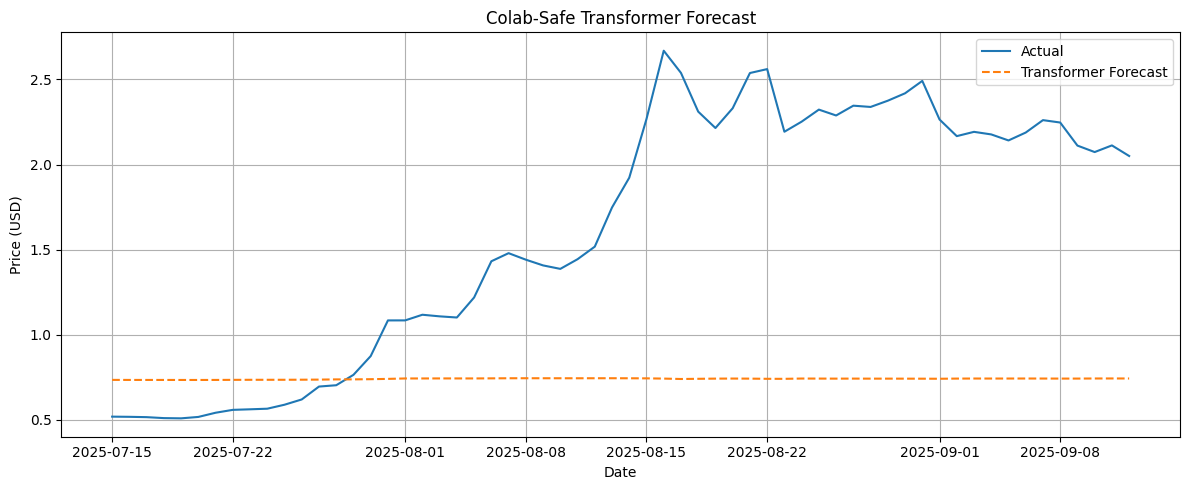


✅ Transformer Evaluation:
MSE: 1.2899 | MAE: 0.9463


In [7]:
# === SAFE TRANSFORMER BLOCK FOR COLAB ===

# STEP 1: IMPORTS
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

# STEP 2: LOAD & REDUCE DATA
df_ext = pd.read_csv('extended_xrp_forecast.csv')
df_ext['Date'] = pd.to_datetime(df_ext['Date'])
series = df_ext['Price'].values[-2500:].reshape(-1, 1)  # last 1500 points

# STEP 3: SCALING & SEQUENCE PREP
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

def create_sequence_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 60
X_seq, y_seq = create_sequence_data(scaled_series, window_size)

X_train, y_train = X_seq[:-60], y_seq[:-60]
X_test, y_test = X_seq[-60:], y_seq[-60:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# STEP 4: DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# STEP 5: POS ENCODING
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# STEP 6: TRANSFORMER MODEL
class CompactTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=32, num_heads=2, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_enc = PositionalEncoding(d_model=model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        return self.decoder(x[:, -1])

# STEP 7: INIT MODEL
model = CompactTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# STEP 8: TRAINING
for epoch in range(40):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f}")

# STEP 9: EVALUATION
model.eval()
with torch.no_grad():
    pred_tf = model(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()

# Squeeze the extra dimension from y_true - REMOVE OR COMMENT OUT THIS LINE
# y_true = y_true.squeeze()

pred_tf_inv = scaler.inverse_transform(pred_tf)
# Ensure y_true is 2D before inverse transform
true_tf_inv = scaler.inverse_transform(y_true.reshape(-1, 1))

# STEP 10: PLOT
plot_dates = df_ext['Date'].iloc[-60:]
plt.figure(figsize=(12, 5))
# Adjust plotting for 2D array
plt.plot(plot_dates, true_tf_inv[:, 0], label='Actual')
plt.plot(plot_dates, pred_tf_inv[:, 0], label='Transformer Forecast', linestyle='--')
plt.title('Colab-Safe Transformer Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# STEP 11: METRICS
# Adjust metric calculations for 2D array
mse = mean_squared_error(true_tf_inv[:, 0], pred_tf_inv[:, 0])
mae = mean_absolute_error(true_tf_inv[:, 0], pred_tf_inv[:, 0])
print(f"\n✅ Transformer Evaluation:\nMSE: {mse:.4f} | MAE: {mae:.4f}")

Epoch 0 | Loss: 0.253074
Epoch 200 | Loss: 0.025446
Epoch 400 | Loss: 0.020738
Epoch 600 | Loss: 0.020534
Epoch 800 | Loss: 0.020415
Epoch 1000 | Loss: 0.020304
Epoch 1200 | Loss: 0.020188
Epoch 1400 | Loss: 0.020030
Epoch 1600 | Loss: 0.019746
Epoch 1800 | Loss: 0.019347
Epoch 2000 | Loss: 0.019043
Epoch 2200 | Loss: 0.018688
Epoch 2400 | Loss: 0.018428


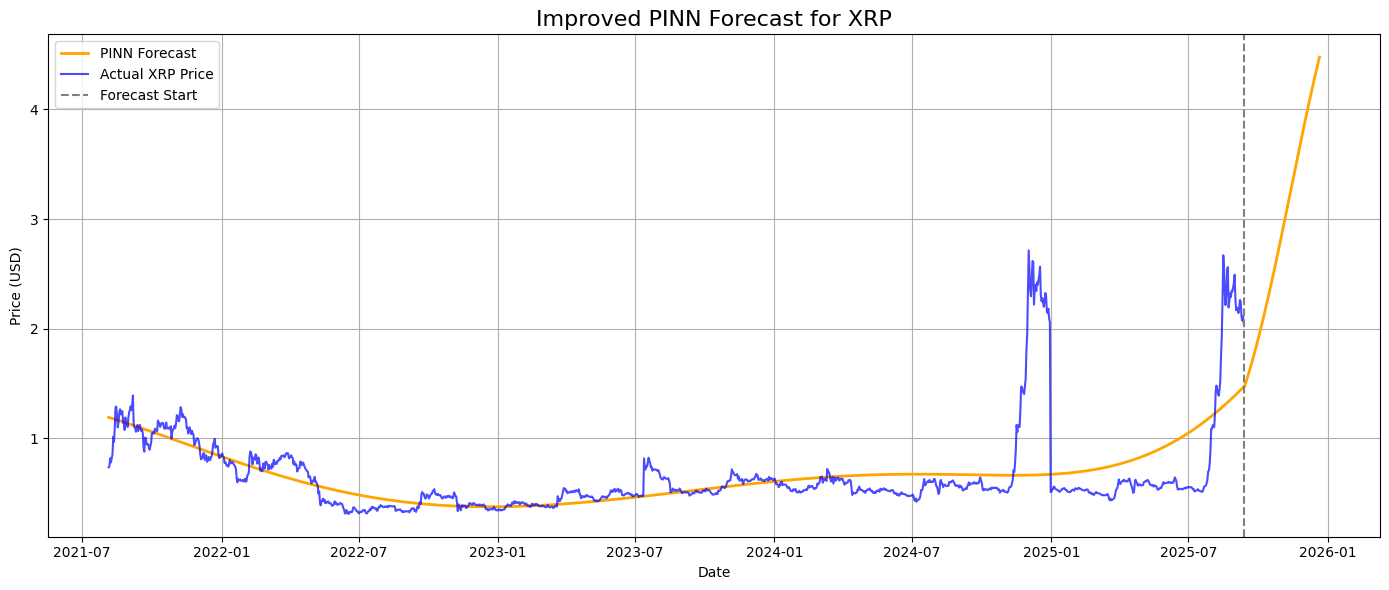

In [11]:
# === STEP 1: IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# === STEP 2: LOAD DATA ===
df_ext = pd.read_csv('extended_xrp_forecast.csv')
df_ext['Date'] = pd.to_datetime(df_ext['Date'])

# Use last 800 points
series = df_ext['Price'].values[-1500:].reshape(-1, 1)

# Scale
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# Normalized time
t = np.linspace(0, 1, len(scaled_series)).reshape(-1, 1)
t_tensor = torch.tensor(t, dtype=torch.float32)
y_tensor = torch.tensor(scaled_series, dtype=torch.float32)

# === STEP 3: SIN ACTIVATION ===
class SinActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

# === STEP 4: PINN MODEL ===
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            SinActivation(),
            nn.Linear(64, 64),
            SinActivation(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
model = PINN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# === STEP 5: TRAINING ===
epochs = 2500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(t_tensor)
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# === STEP 6: FORECAST ===
t_future = np.linspace(1.0, 1.2, 100).reshape(-1, 1)
t_all = np.concatenate([t, t_future])
t_all_tensor = torch.tensor(t_all, dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred_scaled = model(t_all_tensor).numpy()

pred_prices = scaler.inverse_transform(pred_scaled)

# === STEP 7: PLOT ===
# === STEP 7: PLOT ===
last_date = df_ext['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=100)

# Construct all_dates using the dates corresponding to the series and future dates
# The series was taken from the last 1500 points of df_ext
series_dates = df_ext['Date'].iloc[-1500:].values
all_dates = np.concatenate([series_dates, future_dates])

plt.figure(figsize=(14, 6))
plt.plot(all_dates, pred_prices, label='PINN Forecast', color='orange', linewidth=2)
# Plot the actual price series that was used for training/inference
plt.plot(series_dates, series, label='Actual XRP Price', color='blue', alpha=0.7)
plt.axvline(last_date, color='gray', linestyle='--', label='Forecast Start')
plt.title('Improved PINN Forecast for XRP', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()